In [1]:
import sys, os, random, json
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from IPython.display import display

import torch
import torchvision.models as models
import torchvision.transforms as transforms

from sklearn.metrics import roc_curve, roc_auc_score



augmentation unnecessary?!

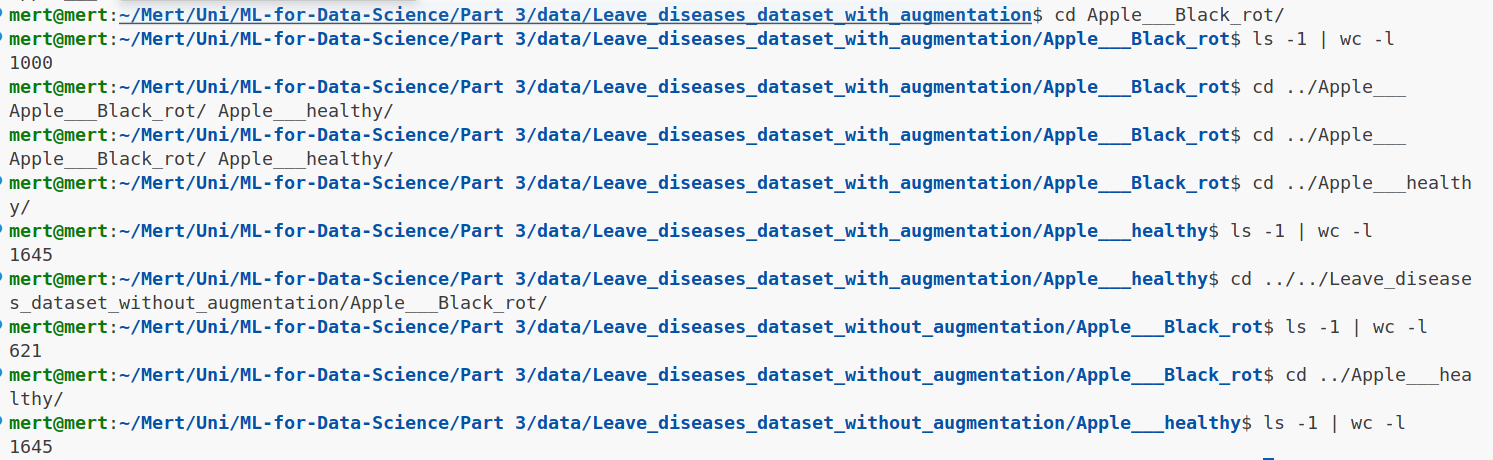

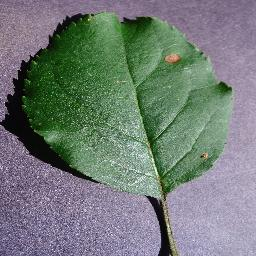

In [2]:
def load_images():


    # Define the base directory and subdirectories
    base_dir = '/home/mert/Mert/Uni/ML-for-Data-Science/Part 3/data/Leave_diseases_dataset_without_augmentation'  # change this to your directory hierarchy
    sub_dirs = ['Apple___healthy', 'Apple___Black_rot']
    
    # Initialize a list to hold the images
    all_images = {}
    indices = {}
    test_images = {}
    random.seed(42)

    # Loop through each subdirectory
    for sub_dir in sub_dirs:
        dir_path = os.path.join(base_dir, sub_dir)

        all_images[sub_dir] = []
        test_images[sub_dir] = []
        
        # Get the list of image files (assuming all files in the directory are images)
        image_files = os.listdir(dir_path)

        # randomly select 130 out of all images ofr training and testing
        indices[sub_dir] = random.sample(range(len(image_files)),130) 
        
        # Load random 100 images
        for i in indices[sub_dir][:100]:
       
            img_path = os.path.join(dir_path, image_files[i])
            try:
                image = Image.open(img_path)
                all_images[sub_dir].append(image)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
   
        # load random 30 images for testing
        for i in indices[sub_dir][100:130]:
            img_path = os.path.join(dir_path, image_files[i])
            try:
                image = Image.open(img_path)
                test_images[sub_dir].append(image)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return all_images, indices, test_images

images, image_indices, test_images = load_images()
images["Apple___Black_rot"][0]
    

In [3]:
len(images["Apple___healthy"])

100

In [4]:
len(images["Apple___healthy"])

100

In [5]:
transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [6]:
def get_features_of_image(image):
    torch.manual_seed(42)
    data = transform(image)
    model = models.vgg16().features

    model.eval()
    with torch.no_grad():
        output = model(data)
        
    return output

#test = get_features_of_image(img)

In [7]:
def show_feature():
    f = get_features_of_image(img)
    testimg = np.array(f[0]*255).astype(np.uint8)
    testimg = Image.fromarray(testimg, mode='L')
    resized_image = testimg.resize((256, 256), Image.NEAREST)
    return resized_image

In [8]:
reduced_images = {key: value[:2] for key, value in images.items()}

In [9]:
list(images.keys())

['Apple___healthy', 'Apple___Black_rot']

In [10]:
def calculate_difference_of_means(images_list):
    classes = list(images_list.keys())
    num_weights = get_features_of_image(images_list[classes[0]][0]).numel()
    feature_vector1 = torch.zeros(num_weights)
    feature_vector2 = torch.zeros(num_weights)

    all_feature_vectors = [] 

    if len(images_list[classes[0]]) < 100:
        path = "test" 
    else: path = "data"

    count=0
    for i in images_list[classes[0]]:
        current = get_features_of_image(i).flatten()
        feature_vector1 += current
        all_feature_vectors.append(current)
        print(f"finished: {count}")
        count +=1
    mean1 = feature_vector1 / len(images_list[classes[0]])

    torch.save(mean1, path+"/mean1.pt")

    for i in images_list[classes[1]]:
        current = get_features_of_image(i).flatten()
        feature_vector2 += current
        all_feature_vectors.append(current)
        print(f"finished: {count}")
        count +=1
    mean2 = feature_vector2 / len(images_list[classes[1]])
    torch.save(mean2, path+"/mean2.pt")

    b = torch.stack(all_feature_vectors)
    print(b.shape)
    c = torch.reshape(b,(2,int(b.shape[0]/2),b.shape[1]))

    torch.save(c, path+"/all_features.pt")
        
    w = (mean2 - mean1) / np.linalg.norm(mean2 - mean1)


    return w

    
#w_reduced = calculate_difference_of_means(reduced_images)    

In [11]:
#calculate_difference_of_means(images)  # CAUTION: Overwrites .pt files and takes 13min on my Laptop

In [12]:
# loads the saved vectors which take long to calculate (10+ min)
mean1 = torch.load("data/mean1.pt")
mean2 = torch.load("data/mean2.pt")
w = (mean2 - mean1) / np.linalg.norm(mean2 - mean1)
all_features = torch.load("data/all_features.pt")

In [13]:
def discriminant_function(feature_x, w):
    return torch.dot(w, feature_x)

dtest = discriminant_function(all_features[1,7], w)
dtest

tensor(6.8549)

In [14]:
test = [[],[]]
for j in range(2):
    for i in range(100):
        test[j].append(discriminant_function(all_features[j,i],w))

test = np.array(test)
print(np.min(test[0]), np.min(test[1]))
print(np.max(test[0]), np.max(test[1]))
print(np.mean(test[0]), np.mean(test[1]))


3.7709236 5.527338
8.455161 8.295368
5.6492443 7.054746


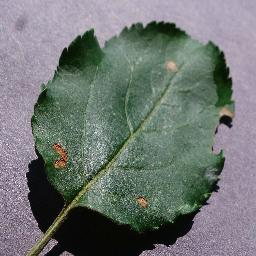

In [15]:
test_images["Apple___Black_rot"][0]

In [16]:
threshold = (mean1 + mean2).dot(w) /2

def classify_new_image(image):
    feature = get_features_of_image(image).flatten()
    discriminant_value = discriminant_function(feature,w)
    classification = 1 if discriminant_value > threshold else 0
    return classification, discriminant_value, feature

classify_new_image(test_images["Apple___healthy"][19])

(0,
 tensor(5.9143),
 tensor([0.0000, 0.0000, 0.0000,  ..., 0.0233, 0.0330, 0.0290]))

In [17]:
def classifiy_dataset(test_images):
    all_classifications = []
    debugging = []

    for target, name in enumerate(test_images):
        for image in test_images[name]: 
           classification, discriminant_value, feature = classify_new_image(image)
           all_classifications.append((target, classification))
           debugging.append((discriminant_value, feature))
    
    return all_classifications, debugging

all_classifications, debugging = classifiy_dataset(test_images)   # I didnt save the test images in .pt file. Just wait 3 min

In [18]:
np.array([True if y == y_pred else False for y,y_pred in all_classifications ]).sum() /60

0.8666666666666667

In [19]:
#var_results =[]
#for variance in [x for x in np.linspace(-1, 1, num=101)]:
#    discriminants = [x for x,y in debugging]
#    thr = (mean1 + mean2).dot(w) /2 + variance
#    test_classifications = [1 if x > thr else 0 for x in discriminants]
#    test_classifications = zip(test_classifications, [true for true, pred in all_classifications] )
#    auc = np.array([True if y == y_pred else False for y,y_pred in test_classifications ]).sum() /60
#    var_results.append(auc)
#np.argmax(var_results), np.max(var_results), var_results

AUC Score: 0.87 on 30 test images for each class


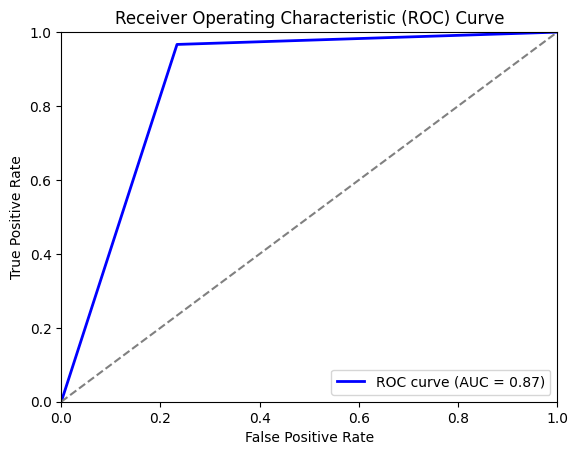

In [23]:

y_test = [true for true, pred in all_classifications] 
y_pred = [pred for true, pred in all_classifications]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc_score:.2f} on {int(len(y_test)/2)} test images for each class")

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()